In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import pickle
from datetime import datetime, timedelta

class AlgaeBloomLabeler:
    def __init__(self, data_path, metadata_path, start_date_str="2024-04-14"):
        self.data = np.load(data_path)  # (n, h, w, c)
        with open(metadata_path, "rb") as f:
            metadata = pickle.load(f)
        self.waves = metadata["wavelengths"]
        self.lat = metadata["lat"]
        self.lon = metadata["lon"]
        self.start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
        self.labels = np.zeros((self.data.shape[0], self.data.shape[1], self.data.shape[2]), dtype=bool)  # bloom mask

    def get_true_color(self, day_idx):
        r = self.data[day_idx, :, :, np.argmin(np.abs(self.waves - 645))]
        g = self.data[day_idx, :, :, np.argmin(np.abs(self.waves - 555))]
        b = self.data[day_idx, :, :, np.argmin(np.abs(self.waves - 450))]
        img = np.stack([r, g, b], axis=-1)
        img = np.clip(img / np.nanmax(img), 0, 1)  # Normalize
        return img

    def label_bounding_box(self, day_idx):
        img = self.get_true_color(day_idx)
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.imshow(img)
        ax.set_title(f"True Color Image: {self.start_date + timedelta(days=day_idx)}")
        self.current_day_idx = day_idx

        def onselect(eclick, erelease):
            # Get pixel coordinates
            x1, y1 = int(eclick.xdata), int(eclick.ydata)
            x2, y2 = int(erelease.xdata), int(erelease.ydata)
            xmin, xmax = sorted([x1, x2])
            ymin, ymax = sorted([y1, y2])
            print(f"Selected pixels: X({xmin}-{xmax}), Y({ymin}-{ymax})")
            # Update labels
            self.labels[day_idx, ymin:ymax, xmin:xmax] = True

        toggle_selector = RectangleSelector(ax, onselect, useblit=True,
                                            button=[1], minspanx=5, minspany=5,
                                            spancoords='pixels', interactive=True)
        plt.show()

    def save_labels(self, out_path):
        np.save(out_path, self.labels)
        print(f"Saved labels to {out_path}")



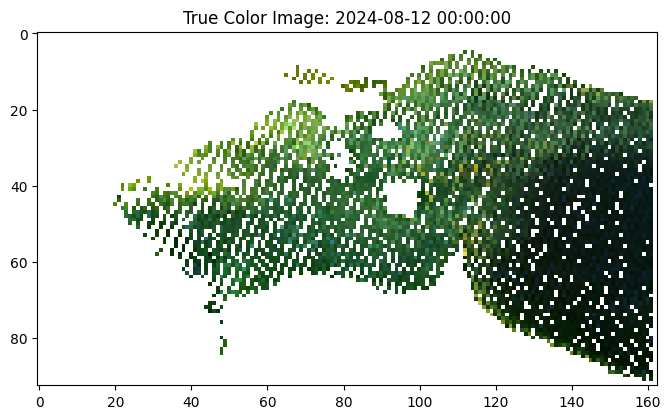

Saved labels to ../Images/algae_bloom_labels.npy


In [2]:
labeler = AlgaeBloomLabeler("../Images/composite_data.npy", "../Images/composite_metadata.pkl")

# Example: label day 120 (use interactive box)
labeler.label_bounding_box(120)

# Save labels
labeler.save_labels("../Images/algae_bloom_labels.npy")
